# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [1]:
import helper
data_dir = './data'

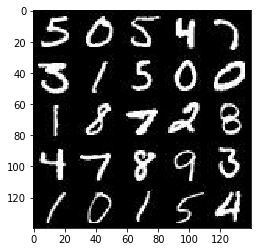

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

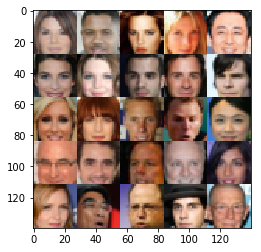

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (), name='learning_rate')
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 256, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x256

        x2 = tf.layers.conv2d(relu1, 512, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x512

        x3 = tf.layers.conv2d(relu2, 1024, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x1024

        x4 = tf.layers.conv2d(relu3, 2048, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        # 2x2x2048

        # Flatten it
        flat = tf.reshape(relu3, (-1, 2*2*2048))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*2048)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 2048))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 1024, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 512, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
       
        x4 = tf.layers.conv2d_transpose(x3, 256, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
        #x5 = tf.layers.conv2d_transpose(x4, 128, 5, strides=2, padding='same')
        #x5 = tf.layers.batch_normalization(x5, training=is_train)
        #x5 = tf.maximum(alpha * x5, x5)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        logits = tf.image.resize_images(logits, (28, 28))
        # 28x28x out_channel_dim
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function

    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    print_every = 10
    show_every=100
    sample_images=12
    
    #tf.reset_default_graph()
        
    input_real, input_z, learning_rate_tf = model_inputs(
        image_width=data_shape[1],
        image_height=data_shape[2],
        image_channels=data_shape[3],
        z_dim=z_dim
    )

    out_channel_dim=data_shape[3]
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_tf, beta1)    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Rescale batch_images to be in range -1 to 1
                batch_images *= 2
                
                # Run optimizers
                _ = sess.run(
                    d_opt, 
                    feed_dict={
                        input_real: batch_images,
                        input_z: batch_z,
                        learning_rate_tf: learning_rate
                    }
                )
                _ = sess.run(
                    g_opt, 
                    feed_dict={
                        input_z: batch_z,
                        input_real: batch_images,
                        learning_rate_tf: learning_rate
                    }
                )

                # added second generator based on this forum post
                # https://discussions.udacity.com/t/you-should-increase-batch-size-by-a-factor-of-two-inside-the-inner-for-loop/634945
                #_ = sess.run(
                #    g_opt, 
                #    feed_dict={
                #        input_z: batch_z,
                #        input_real: batch_images,
                #        learning_rate_tf: learning_rate
                #    }
                #)

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, sample_images, input_z, out_channel_dim, data_image_mode)

        show_generator_output(sess, sample_images, input_z, out_channel_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0506... Generator Loss: 42.4560
Epoch 1/2... Discriminator Loss: 0.0000... Generator Loss: 41.2563
Epoch 1/2... Discriminator Loss: 0.0000... Generator Loss: 39.9536
Epoch 1/2... Discriminator Loss: 0.0000... Generator Loss: 38.2274
Epoch 1/2... Discriminator Loss: 0.0000... Generator Loss: 38.1312
Epoch 1/2... Discriminator Loss: 0.0000... Generator Loss: 38.1182
Epoch 1/2... Discriminator Loss: 0.0010... Generator Loss: 36.1315
Epoch 1/2... Discriminator Loss: 0.0000... Generator Loss: 32.9255
Epoch 1/2... Discriminator Loss: 0.0000... Generator Loss: 32.7550
Epoch 1/2... Discriminator Loss: 0.0000... Generator Loss: 31.3752


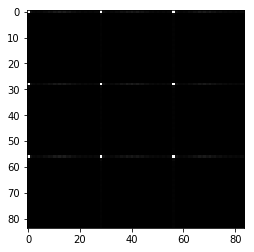

Epoch 1/2... Discriminator Loss: 6.6056... Generator Loss: 8.3844
Epoch 1/2... Discriminator Loss: 0.8344... Generator Loss: 1.8009
Epoch 1/2... Discriminator Loss: 2.9858... Generator Loss: 0.5653
Epoch 1/2... Discriminator Loss: 2.9594... Generator Loss: 5.0316
Epoch 1/2... Discriminator Loss: 0.3692... Generator Loss: 2.4896
Epoch 1/2... Discriminator Loss: 6.0770... Generator Loss: 5.3959
Epoch 1/2... Discriminator Loss: 0.8808... Generator Loss: 1.3032
Epoch 1/2... Discriminator Loss: 3.1589... Generator Loss: 0.1311
Epoch 1/2... Discriminator Loss: 1.9589... Generator Loss: 2.6736
Epoch 1/2... Discriminator Loss: 2.1526... Generator Loss: 1.9712


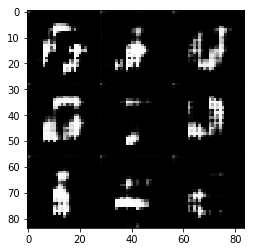

Epoch 1/2... Discriminator Loss: 1.1692... Generator Loss: 1.6477
Epoch 1/2... Discriminator Loss: 1.5371... Generator Loss: 2.9068
Epoch 1/2... Discriminator Loss: 1.3380... Generator Loss: 1.5919
Epoch 1/2... Discriminator Loss: 1.6597... Generator Loss: 0.3673
Epoch 1/2... Discriminator Loss: 1.3517... Generator Loss: 1.8469
Epoch 1/2... Discriminator Loss: 1.1895... Generator Loss: 1.1413
Epoch 1/2... Discriminator Loss: 1.2350... Generator Loss: 0.7791
Epoch 1/2... Discriminator Loss: 1.1318... Generator Loss: 0.6595
Epoch 1/2... Discriminator Loss: 0.8777... Generator Loss: 1.1405
Epoch 1/2... Discriminator Loss: 1.7662... Generator Loss: 2.2887


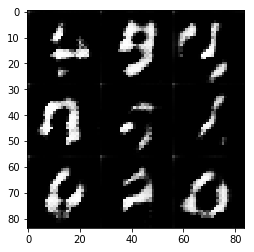

Epoch 1/2... Discriminator Loss: 1.0645... Generator Loss: 1.5563
Epoch 1/2... Discriminator Loss: 1.3812... Generator Loss: 1.2724
Epoch 1/2... Discriminator Loss: 1.4484... Generator Loss: 0.6354
Epoch 1/2... Discriminator Loss: 1.0324... Generator Loss: 1.1911
Epoch 1/2... Discriminator Loss: 1.3096... Generator Loss: 0.7401
Epoch 1/2... Discriminator Loss: 1.3347... Generator Loss: 1.0384
Epoch 1/2... Discriminator Loss: 1.2417... Generator Loss: 0.6064
Epoch 1/2... Discriminator Loss: 1.2558... Generator Loss: 1.2710
Epoch 1/2... Discriminator Loss: 0.9977... Generator Loss: 1.6062
Epoch 1/2... Discriminator Loss: 0.7016... Generator Loss: 1.4557


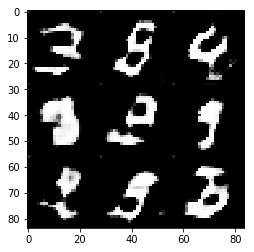

Epoch 1/2... Discriminator Loss: 1.3407... Generator Loss: 1.2406
Epoch 1/2... Discriminator Loss: 0.9207... Generator Loss: 1.2553
Epoch 1/2... Discriminator Loss: 1.3664... Generator Loss: 0.4400
Epoch 1/2... Discriminator Loss: 1.1843... Generator Loss: 1.7345
Epoch 1/2... Discriminator Loss: 1.1921... Generator Loss: 2.2415
Epoch 1/2... Discriminator Loss: 2.1528... Generator Loss: 1.9656
Epoch 1/2... Discriminator Loss: 1.2575... Generator Loss: 1.4956
Epoch 1/2... Discriminator Loss: 1.2834... Generator Loss: 0.4625
Epoch 1/2... Discriminator Loss: 1.4855... Generator Loss: 1.0965
Epoch 1/2... Discriminator Loss: 1.4803... Generator Loss: 0.8910


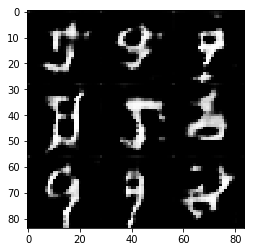

Epoch 1/2... Discriminator Loss: 1.1454... Generator Loss: 0.9707
Epoch 1/2... Discriminator Loss: 1.5304... Generator Loss: 0.4086
Epoch 1/2... Discriminator Loss: 1.2532... Generator Loss: 0.5341
Epoch 1/2... Discriminator Loss: 1.0166... Generator Loss: 1.2314
Epoch 1/2... Discriminator Loss: 1.2653... Generator Loss: 0.5119
Epoch 1/2... Discriminator Loss: 1.1476... Generator Loss: 0.6282
Epoch 1/2... Discriminator Loss: 1.3404... Generator Loss: 0.4971
Epoch 1/2... Discriminator Loss: 1.2546... Generator Loss: 1.1530
Epoch 1/2... Discriminator Loss: 1.2469... Generator Loss: 0.7010
Epoch 1/2... Discriminator Loss: 1.2088... Generator Loss: 1.2184


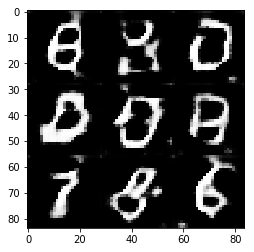

Epoch 1/2... Discriminator Loss: 1.2091... Generator Loss: 1.1108
Epoch 1/2... Discriminator Loss: 1.1591... Generator Loss: 1.5339
Epoch 1/2... Discriminator Loss: 1.3355... Generator Loss: 0.6403
Epoch 1/2... Discriminator Loss: 1.4364... Generator Loss: 0.4426
Epoch 1/2... Discriminator Loss: 1.2817... Generator Loss: 0.4834
Epoch 1/2... Discriminator Loss: 1.3998... Generator Loss: 0.7778
Epoch 1/2... Discriminator Loss: 1.3373... Generator Loss: 1.0613
Epoch 1/2... Discriminator Loss: 1.2623... Generator Loss: 0.4975
Epoch 1/2... Discriminator Loss: 1.2676... Generator Loss: 1.3055
Epoch 1/2... Discriminator Loss: 1.1322... Generator Loss: 1.3441


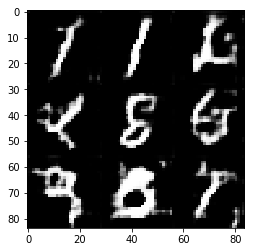

Epoch 1/2... Discriminator Loss: 1.2265... Generator Loss: 1.0905
Epoch 1/2... Discriminator Loss: 1.1299... Generator Loss: 1.3035
Epoch 1/2... Discriminator Loss: 1.6432... Generator Loss: 0.3687
Epoch 1/2... Discriminator Loss: 1.2058... Generator Loss: 0.8997
Epoch 1/2... Discriminator Loss: 0.9583... Generator Loss: 1.7179
Epoch 1/2... Discriminator Loss: 1.5310... Generator Loss: 0.3957
Epoch 1/2... Discriminator Loss: 1.5917... Generator Loss: 0.4560
Epoch 1/2... Discriminator Loss: 1.3011... Generator Loss: 0.4731
Epoch 1/2... Discriminator Loss: 1.8275... Generator Loss: 2.7201
Epoch 1/2... Discriminator Loss: 1.2753... Generator Loss: 0.5481


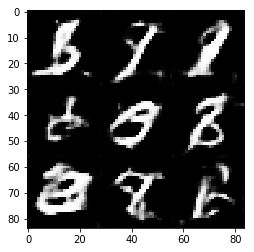

Epoch 1/2... Discriminator Loss: 1.0519... Generator Loss: 1.0346
Epoch 1/2... Discriminator Loss: 1.0822... Generator Loss: 1.6296
Epoch 1/2... Discriminator Loss: 1.1211... Generator Loss: 0.9042
Epoch 1/2... Discriminator Loss: 1.2760... Generator Loss: 0.6532
Epoch 1/2... Discriminator Loss: 1.2639... Generator Loss: 0.6094
Epoch 1/2... Discriminator Loss: 1.1863... Generator Loss: 0.7428
Epoch 1/2... Discriminator Loss: 1.0134... Generator Loss: 0.9493
Epoch 1/2... Discriminator Loss: 1.2661... Generator Loss: 1.0978
Epoch 1/2... Discriminator Loss: 1.0778... Generator Loss: 1.3038
Epoch 1/2... Discriminator Loss: 1.1413... Generator Loss: 0.9807


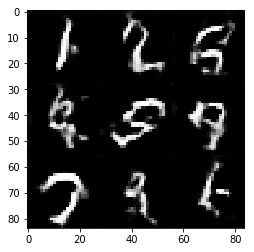

Epoch 1/2... Discriminator Loss: 1.1730... Generator Loss: 0.7590
Epoch 1/2... Discriminator Loss: 1.1111... Generator Loss: 0.8943
Epoch 1/2... Discriminator Loss: 1.2069... Generator Loss: 1.6704
Epoch 2/2... Discriminator Loss: 1.1411... Generator Loss: 1.0405
Epoch 2/2... Discriminator Loss: 1.3250... Generator Loss: 0.4775
Epoch 2/2... Discriminator Loss: 1.3580... Generator Loss: 0.5566
Epoch 2/2... Discriminator Loss: 1.0502... Generator Loss: 0.8527
Epoch 2/2... Discriminator Loss: 1.1581... Generator Loss: 0.7129
Epoch 2/2... Discriminator Loss: 1.2361... Generator Loss: 0.6135
Epoch 2/2... Discriminator Loss: 1.3371... Generator Loss: 0.9303


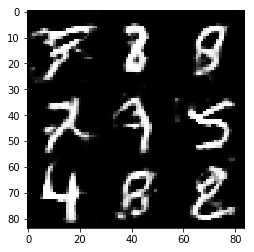

Epoch 2/2... Discriminator Loss: 1.5234... Generator Loss: 2.4729
Epoch 2/2... Discriminator Loss: 1.0153... Generator Loss: 0.9284
Epoch 2/2... Discriminator Loss: 1.2091... Generator Loss: 0.6424
Epoch 2/2... Discriminator Loss: 1.0985... Generator Loss: 0.7941
Epoch 2/2... Discriminator Loss: 1.1684... Generator Loss: 0.9486
Epoch 2/2... Discriminator Loss: 1.2264... Generator Loss: 0.9617
Epoch 2/2... Discriminator Loss: 1.2673... Generator Loss: 0.5862
Epoch 2/2... Discriminator Loss: 1.2218... Generator Loss: 0.7500
Epoch 2/2... Discriminator Loss: 1.1232... Generator Loss: 0.8817
Epoch 2/2... Discriminator Loss: 1.1380... Generator Loss: 0.7207


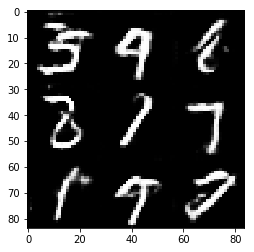

Epoch 2/2... Discriminator Loss: 1.1459... Generator Loss: 0.9335
Epoch 2/2... Discriminator Loss: 0.9763... Generator Loss: 1.1800
Epoch 2/2... Discriminator Loss: 1.1786... Generator Loss: 1.6552
Epoch 2/2... Discriminator Loss: 0.9722... Generator Loss: 1.1060
Epoch 2/2... Discriminator Loss: 1.0112... Generator Loss: 0.8338
Epoch 2/2... Discriminator Loss: 1.3886... Generator Loss: 0.8232
Epoch 2/2... Discriminator Loss: 1.4426... Generator Loss: 0.4022
Epoch 2/2... Discriminator Loss: 1.5905... Generator Loss: 1.9802
Epoch 2/2... Discriminator Loss: 1.0627... Generator Loss: 1.0585
Epoch 2/2... Discriminator Loss: 0.9682... Generator Loss: 1.3913


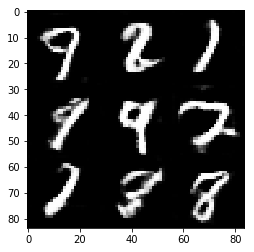

Epoch 2/2... Discriminator Loss: 1.1702... Generator Loss: 1.2938
Epoch 2/2... Discriminator Loss: 1.2192... Generator Loss: 0.6094
Epoch 2/2... Discriminator Loss: 1.0056... Generator Loss: 0.9301
Epoch 2/2... Discriminator Loss: 1.4227... Generator Loss: 0.5215
Epoch 2/2... Discriminator Loss: 1.1236... Generator Loss: 1.1791
Epoch 2/2... Discriminator Loss: 1.0019... Generator Loss: 1.2831
Epoch 2/2... Discriminator Loss: 1.4158... Generator Loss: 0.5333
Epoch 2/2... Discriminator Loss: 1.3168... Generator Loss: 0.6711
Epoch 2/2... Discriminator Loss: 1.2631... Generator Loss: 0.8848
Epoch 2/2... Discriminator Loss: 1.1630... Generator Loss: 0.8592


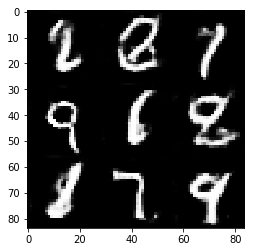

Epoch 2/2... Discriminator Loss: 1.1356... Generator Loss: 0.8568
Epoch 2/2... Discriminator Loss: 0.9987... Generator Loss: 1.1925
Epoch 2/2... Discriminator Loss: 1.2726... Generator Loss: 0.6530
Epoch 2/2... Discriminator Loss: 1.3233... Generator Loss: 0.5498
Epoch 2/2... Discriminator Loss: 0.9968... Generator Loss: 1.0461
Epoch 2/2... Discriminator Loss: 1.3104... Generator Loss: 1.4609
Epoch 2/2... Discriminator Loss: 1.1758... Generator Loss: 0.9847
Epoch 2/2... Discriminator Loss: 1.2102... Generator Loss: 0.6857
Epoch 2/2... Discriminator Loss: 1.0784... Generator Loss: 1.0286
Epoch 2/2... Discriminator Loss: 1.0188... Generator Loss: 1.1382


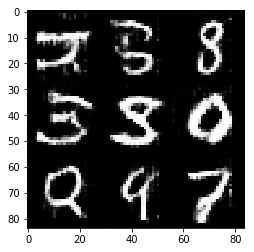

Epoch 2/2... Discriminator Loss: 1.0440... Generator Loss: 0.9161
Epoch 2/2... Discriminator Loss: 1.2113... Generator Loss: 1.0075
Epoch 2/2... Discriminator Loss: 1.0986... Generator Loss: 0.8329
Epoch 2/2... Discriminator Loss: 1.2308... Generator Loss: 0.9401
Epoch 2/2... Discriminator Loss: 1.3742... Generator Loss: 1.6410
Epoch 2/2... Discriminator Loss: 1.5220... Generator Loss: 0.9960
Epoch 2/2... Discriminator Loss: 1.1365... Generator Loss: 0.9488
Epoch 2/2... Discriminator Loss: 1.3789... Generator Loss: 0.4771
Epoch 2/2... Discriminator Loss: 1.5284... Generator Loss: 0.3683
Epoch 2/2... Discriminator Loss: 1.2610... Generator Loss: 0.7319


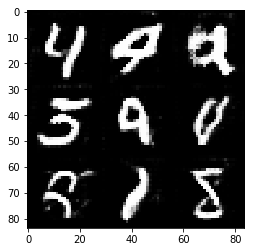

Epoch 2/2... Discriminator Loss: 1.1028... Generator Loss: 0.9984
Epoch 2/2... Discriminator Loss: 1.1671... Generator Loss: 0.8790
Epoch 2/2... Discriminator Loss: 1.1869... Generator Loss: 0.7171
Epoch 2/2... Discriminator Loss: 1.2171... Generator Loss: 1.2213
Epoch 2/2... Discriminator Loss: 1.2431... Generator Loss: 0.6117
Epoch 2/2... Discriminator Loss: 1.1079... Generator Loss: 0.7436
Epoch 2/2... Discriminator Loss: 1.3509... Generator Loss: 0.6957
Epoch 2/2... Discriminator Loss: 1.1965... Generator Loss: 0.5711
Epoch 2/2... Discriminator Loss: 1.0288... Generator Loss: 1.1319
Epoch 2/2... Discriminator Loss: 1.2864... Generator Loss: 0.8988


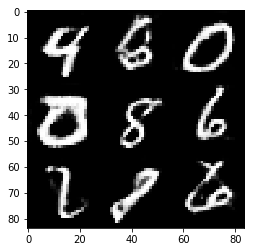

Epoch 2/2... Discriminator Loss: 1.1258... Generator Loss: 0.7798
Epoch 2/2... Discriminator Loss: 1.1814... Generator Loss: 0.9295
Epoch 2/2... Discriminator Loss: 1.2801... Generator Loss: 0.5197
Epoch 2/2... Discriminator Loss: 1.4166... Generator Loss: 1.5463
Epoch 2/2... Discriminator Loss: 1.2612... Generator Loss: 0.9435
Epoch 2/2... Discriminator Loss: 1.1783... Generator Loss: 0.6762
Epoch 2/2... Discriminator Loss: 1.5694... Generator Loss: 0.3851
Epoch 2/2... Discriminator Loss: 1.0618... Generator Loss: 1.0145
Epoch 2/2... Discriminator Loss: 1.2967... Generator Loss: 0.5674
Epoch 2/2... Discriminator Loss: 1.1577... Generator Loss: 0.8937


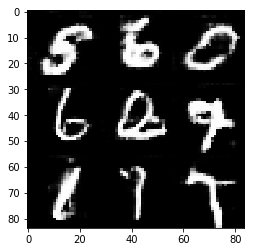

Epoch 2/2... Discriminator Loss: 1.2623... Generator Loss: 0.6912
Epoch 2/2... Discriminator Loss: 1.5676... Generator Loss: 1.4445
Epoch 2/2... Discriminator Loss: 1.2878... Generator Loss: 0.6684
Epoch 2/2... Discriminator Loss: 1.3336... Generator Loss: 0.8894
Epoch 2/2... Discriminator Loss: 1.2467... Generator Loss: 0.6484
Epoch 2/2... Discriminator Loss: 1.2720... Generator Loss: 1.3600
Epoch 2/2... Discriminator Loss: 1.1798... Generator Loss: 1.0015
Epoch 2/2... Discriminator Loss: 1.6013... Generator Loss: 0.3962
Epoch 2/2... Discriminator Loss: 1.1509... Generator Loss: 0.8110
Epoch 2/2... Discriminator Loss: 1.3220... Generator Loss: 1.3253


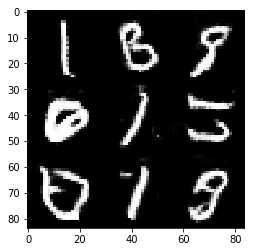

Epoch 2/2... Discriminator Loss: 1.4353... Generator Loss: 0.4858
Epoch 2/2... Discriminator Loss: 1.3278... Generator Loss: 0.8532
Epoch 2/2... Discriminator Loss: 1.2556... Generator Loss: 0.7799
Epoch 2/2... Discriminator Loss: 1.1649... Generator Loss: 0.7454
Epoch 2/2... Discriminator Loss: 1.3132... Generator Loss: 0.6511
Epoch 2/2... Discriminator Loss: 1.4104... Generator Loss: 0.6155
Epoch 2/2... Discriminator Loss: 1.3603... Generator Loss: 1.1541


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.1008... Generator Loss: 12.6372
Epoch 1/1... Discriminator Loss: 0.0113... Generator Loss: 6.8129
Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 3.5185
Epoch 1/1... Discriminator Loss: 0.1309... Generator Loss: 4.2447
Epoch 1/1... Discriminator Loss: 0.2104... Generator Loss: 8.4896
Epoch 1/1... Discriminator Loss: 0.2372... Generator Loss: 3.4770
Epoch 1/1... Discriminator Loss: 1.9214... Generator Loss: 9.7461
Epoch 1/1... Discriminator Loss: 0.0705... Generator Loss: 4.1641
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 3.6929
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 1.0187


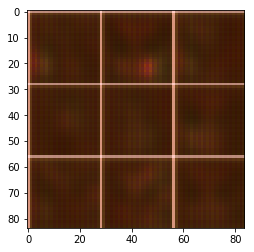

Epoch 1/1... Discriminator Loss: 1.8001... Generator Loss: 1.2249
Epoch 1/1... Discriminator Loss: 0.3142... Generator Loss: 1.9757
Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 2.0571
Epoch 1/1... Discriminator Loss: 0.7668... Generator Loss: 1.7629
Epoch 1/1... Discriminator Loss: 1.8160... Generator Loss: 1.7284
Epoch 1/1... Discriminator Loss: 0.5905... Generator Loss: 2.4639
Epoch 1/1... Discriminator Loss: 0.3812... Generator Loss: 2.5830
Epoch 1/1... Discriminator Loss: 0.6486... Generator Loss: 2.1167
Epoch 1/1... Discriminator Loss: 0.3051... Generator Loss: 4.7561
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.7402


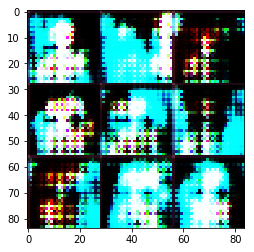

Epoch 1/1... Discriminator Loss: 0.0107... Generator Loss: 10.0128
Epoch 1/1... Discriminator Loss: 0.0400... Generator Loss: 4.2956
Epoch 1/1... Discriminator Loss: 0.0199... Generator Loss: 5.2650
Epoch 1/1... Discriminator Loss: 0.0241... Generator Loss: 5.1681
Epoch 1/1... Discriminator Loss: 0.1723... Generator Loss: 2.4981
Epoch 1/1... Discriminator Loss: 0.0515... Generator Loss: 8.3421
Epoch 1/1... Discriminator Loss: 1.5130... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 3.1785... Generator Loss: 2.5696
Epoch 1/1... Discriminator Loss: 0.8650... Generator Loss: 10.9254
Epoch 1/1... Discriminator Loss: 0.0901... Generator Loss: 3.0885


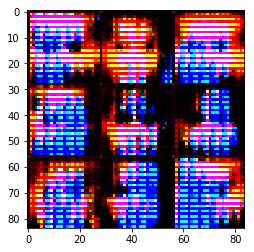

Epoch 1/1... Discriminator Loss: 0.0261... Generator Loss: 5.4134
Epoch 1/1... Discriminator Loss: 0.0291... Generator Loss: 6.2386
Epoch 1/1... Discriminator Loss: 0.1822... Generator Loss: 2.8900
Epoch 1/1... Discriminator Loss: 0.9257... Generator Loss: 0.9981
Epoch 1/1... Discriminator Loss: 0.0893... Generator Loss: 4.5865
Epoch 1/1... Discriminator Loss: 1.7759... Generator Loss: 0.3715
Epoch 1/1... Discriminator Loss: 0.6736... Generator Loss: 5.9261
Epoch 1/1... Discriminator Loss: 0.2162... Generator Loss: 2.6362
Epoch 1/1... Discriminator Loss: 0.0442... Generator Loss: 4.4482
Epoch 1/1... Discriminator Loss: 0.0195... Generator Loss: 4.9749


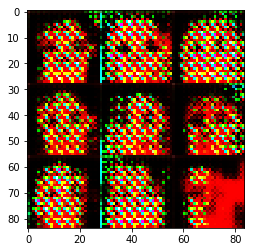

Epoch 1/1... Discriminator Loss: 0.0571... Generator Loss: 3.5276
Epoch 1/1... Discriminator Loss: 0.0222... Generator Loss: 4.4399
Epoch 1/1... Discriminator Loss: 0.0190... Generator Loss: 4.6656
Epoch 1/1... Discriminator Loss: 0.0094... Generator Loss: 5.4656
Epoch 1/1... Discriminator Loss: 0.0099... Generator Loss: 5.7321
Epoch 1/1... Discriminator Loss: 0.0042... Generator Loss: 7.4572
Epoch 1/1... Discriminator Loss: 0.0312... Generator Loss: 4.2635
Epoch 1/1... Discriminator Loss: 0.0213... Generator Loss: 10.0941
Epoch 1/1... Discriminator Loss: 0.6363... Generator Loss: 2.6423
Epoch 1/1... Discriminator Loss: 0.7355... Generator Loss: 1.2852


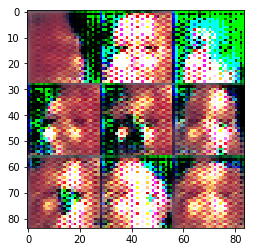

Epoch 1/1... Discriminator Loss: 0.7170... Generator Loss: 1.1602
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 2.2619
Epoch 1/1... Discriminator Loss: 0.8564... Generator Loss: 1.0731
Epoch 1/1... Discriminator Loss: 1.5357... Generator Loss: 1.4828
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 1.0943
Epoch 1/1... Discriminator Loss: 2.8422... Generator Loss: 3.2917
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 2.0740... Generator Loss: 0.3488
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 1.2698


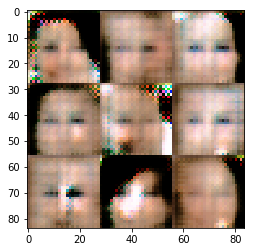

Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 2.4692... Generator Loss: 0.2133
Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 1.3475
Epoch 1/1... Discriminator Loss: 1.5537... Generator Loss: 0.5726
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 1.2354
Epoch 1/1... Discriminator Loss: 1.5236... Generator Loss: 0.4427
Epoch 1/1... Discriminator Loss: 2.8709... Generator Loss: 3.1703
Epoch 1/1... Discriminator Loss: 0.9577... Generator Loss: 0.9468
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 1.2642


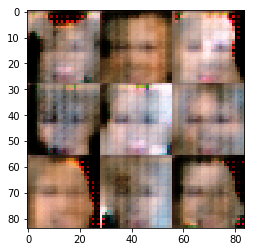

Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.9470
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 1.3322
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 1.5224
Epoch 1/1... Discriminator Loss: 0.9409... Generator Loss: 0.9122
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.5847
Epoch 1/1... Discriminator Loss: 1.1458... Generator Loss: 1.1717
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 0.6369


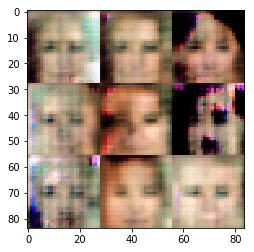

Epoch 1/1... Discriminator Loss: 0.6278... Generator Loss: 2.0546
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 0.5607
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 1.4782
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.6646... Generator Loss: 1.6139
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 1.1068
Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 1.0615
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 1.5493
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 1.6505


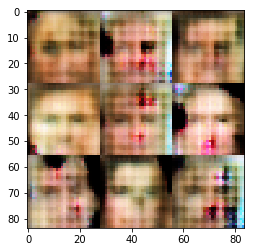

Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 1.6139
Epoch 1/1... Discriminator Loss: 3.7997... Generator Loss: 4.6726
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 0.9059
Epoch 1/1... Discriminator Loss: 1.5670... Generator Loss: 0.3365
Epoch 1/1... Discriminator Loss: 1.0714... Generator Loss: 1.9999
Epoch 1/1... Discriminator Loss: 1.0277... Generator Loss: 1.0530
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.4120
Epoch 1/1... Discriminator Loss: 0.7921... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.7554... Generator Loss: 0.3421


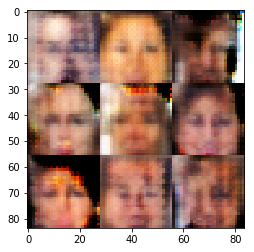

Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 1.3865
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 1.0583
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.8909
Epoch 1/1... Discriminator Loss: 0.7880... Generator Loss: 1.0890
Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 0.9767
Epoch 1/1... Discriminator Loss: 1.1046... Generator Loss: 0.9809
Epoch 1/1... Discriminator Loss: 0.7329... Generator Loss: 1.4329
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 1.9746


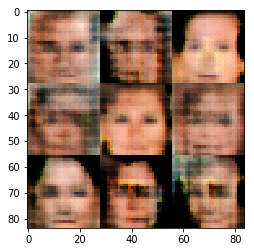

Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 1.0682
Epoch 1/1... Discriminator Loss: 1.5735... Generator Loss: 1.6527
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 1.4007
Epoch 1/1... Discriminator Loss: 0.9867... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.6743... Generator Loss: 4.0407
Epoch 1/1... Discriminator Loss: 1.0487... Generator Loss: 1.0173
Epoch 1/1... Discriminator Loss: 0.6806... Generator Loss: 1.5212
Epoch 1/1... Discriminator Loss: 1.7437... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 1.7335


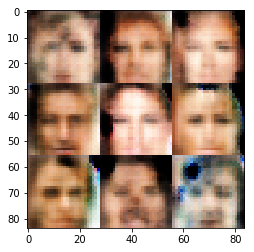

Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 1.0377... Generator Loss: 0.9568
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.0418... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.9885
Epoch 1/1... Discriminator Loss: 1.6702... Generator Loss: 1.4438
Epoch 1/1... Discriminator Loss: 1.5645... Generator Loss: 0.5996


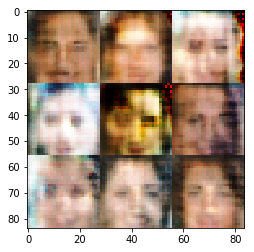

Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.0865... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.4578
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.9323
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.9509
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 1.2348
Epoch 1/1... Discriminator Loss: 1.6866... Generator Loss: 0.4108
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.9998
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 1.3452


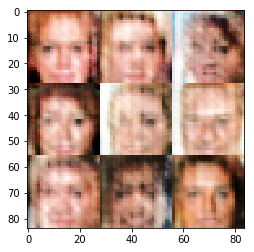

Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.5449
Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 0.9597
Epoch 1/1... Discriminator Loss: 1.5129... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 0.8879
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 1.0024
Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 0.9556


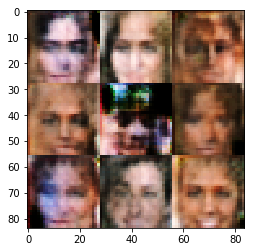

Epoch 1/1... Discriminator Loss: 1.1655... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.8870
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 1.2918
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.8943
Epoch 1/1... Discriminator Loss: 1.5277... Generator Loss: 0.9150
Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 1.0022
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.5586
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 1.0995


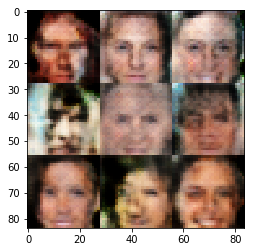

Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 1.1143
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.5649
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 1.2211
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.7434


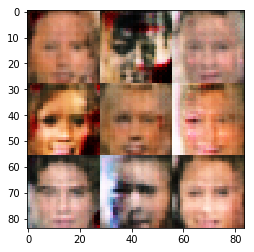

Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.8647
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.9876
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 0.9878... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.7631


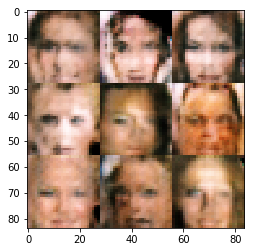

Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.5633
Epoch 1/1... Discriminator Loss: 1.5020... Generator Loss: 0.6054
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 1.0191
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 1.1072
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7389


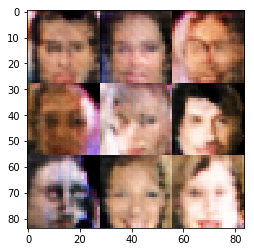

Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 1.0891
Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.3938
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.4109
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.7493


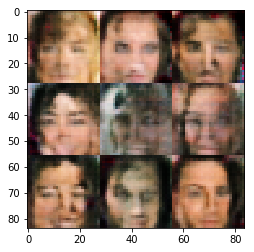

Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 0.8703
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 1.0019
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 1.2159
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 1.2262
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.1098... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.9429
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.5780


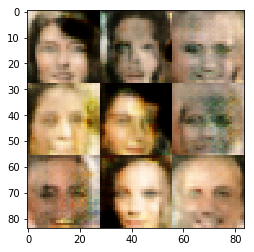

Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.8393
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.5862
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7516


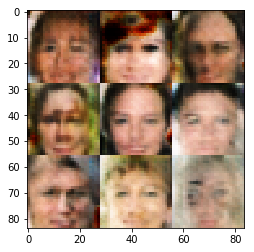

Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 1.0171
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.9613
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 1.0744
Epoch 1/1... Discriminator Loss: 1.1238... Generator Loss: 0.7532


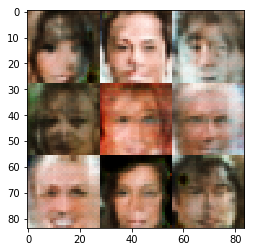

Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.5943... Generator Loss: 1.2854
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 0.9171
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.9993
Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.5808
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.8125


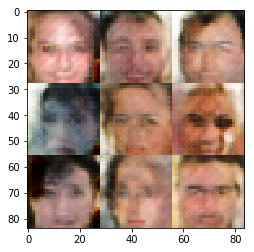

Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.9089
Epoch 1/1... Discriminator Loss: 1.5193... Generator Loss: 0.4623
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.6660... Generator Loss: 0.2995
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.9935


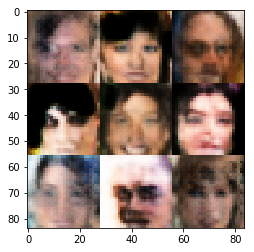

Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.5377
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 0.9638... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 0.8159


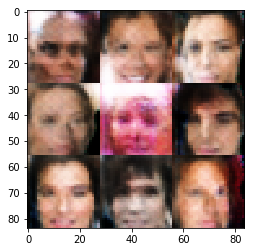

Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.4846... Generator Loss: 0.4972
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.5242... Generator Loss: 0.5014


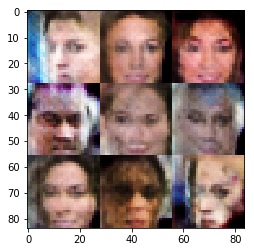

Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.8481
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.6306
Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.5507
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.7351


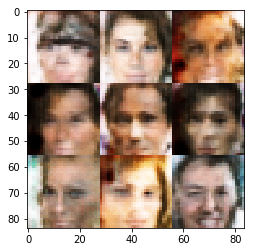

Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.5081... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.0507... Generator Loss: 0.8952
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.5946
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.0006... Generator Loss: 0.9414


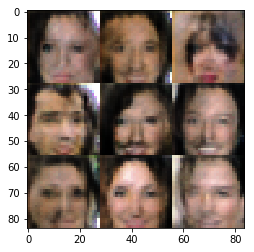

Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 0.3721
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.2454... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.7579


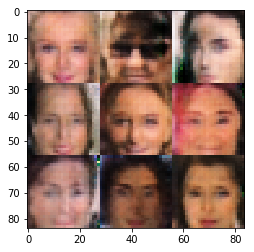

Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 1.0814
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.8441


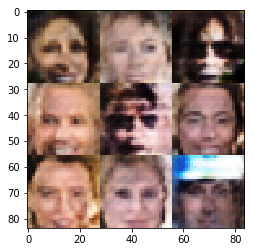

Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.8565
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.4901
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 0.8588


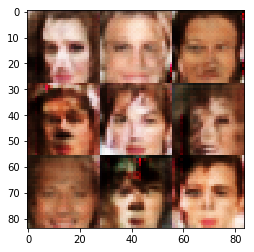

In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.